# Introdução ao Aprendizado Profundo com PyTorch

No Capítulo 10, aprendemos a construir, treinar e ajustar redes neurais artificiais (ANNs) usando PyTorch.  
Entretanto, as redes abordadas até agora eram rasas, contendo apenas poucas camadas ocultas.

Mas e se o problema for mais complexo — como detectar centenas de objetos em imagens de alta resolução?  
Nesse caso, precisamos de redes neurais profundas (DNNs), com dezenas ou até centenas de camadas, e milhares ou milhões de conexões entre neurônios.

Treinar redes tão profundas, porém, traz diversos desafios.

## Desafios do Treinamento de Redes Profundas

**Gradientes que desaparecem ou explodem:**  
Durante o backpropagation, os gradientes podem ficar muito pequenos ou muito grandes, dificultando o treinamento das camadas inferiores.

**Falta de dados rotulados:**  
Redes grandes exigem muitos dados para aprender. Às vezes, é caro ou inviável rotular um conjunto suficientemente grande.

**Treinamento extremamente lento:**  
Quanto mais profunda a rede, maior o custo computacional e o tempo de convergência.

**Risco de sobreajuste (overfitting):**  
Modelos com milhões de parâmetros podem memorizar o conjunto de treino, perdendo capacidade de generalização, especialmente com poucos dados ou dados ruidosos.

## Soluções e Técnicas que Serão Abordadas

Neste capítulo, veremos estratégias para superar esses desafios, incluindo:

### Problema dos gradientes:
- Inicialização inteligente de pesos  
- Funções de ativação aprimoradas  
- Normalização em lote (Batch Normalization) e por camada (Layer Normalization)  
- Gradient clipping  

### Poucos dados rotulados:
- Transfer Learning (aprendizado por transferência)  
- Unsupervised pretraining (pré-treinamento não supervisionado)  

### Aceleração do treinamento:
- Otimizadores avançados  
- Ajuste dinâmico da learning rate durante o treino  

### Regularização de grandes redes:
- Penalizações ℓ₁ e ℓ₂  
- Dropout e Monte Carlo Dropout  
- Max-norm regularization  


### Setup

In [1]:
import sys

assert sys.version_info >= (3, 10)

#Are we using Colab or Kaggle?

In [2]:
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

IS_COLAB = "google.colab" in sys.modules  
IS_KAGGLE = "kaggle_secrets" in sys.modules  
If using Colab, the TorchMetrics library is not pre-installed so we must install it manually:


In [3]:
if IS_COLAB:
    %pip install -q torchmetrics

We also need PyTorch ≥ 2.6.0:




In [4]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

This chapter can be very slow without a hardware accelerator, so if we can find one, let's use it:


In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cpu'

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Vanishing/Exploding Gradients Problem

No Cap. 10 treinamos **redes rasas** com PyTorch. Para problemas complexos (p.ex., **detectar centenas de objetos** em imagens de alta resolução), precisamos de **redes profundas** com **dezenas/centenas de camadas** e **milhões de parâmetros** — e isso traz desafios: **gradientes instáveis (somindo/explodindo)**, **poucos dados rotulados**, **treino lento** e **alto risco de overfitting**.

Este capítulo apresenta **técnicas para cada desafio**: inicialização de pesos mais inteligente, **funções de ativação** melhores, **batch norm** e **layer norm**, **gradient clipping**; **transfer learning** e **pré-treino não supervisionado** quando há poucos rótulos; **otimizadores** que aceleram o treino; **agendamento de taxa de aprendizado**; e **regularização** (ℓ1/ℓ2, **dropout**, **MC dropout**, **max-norm**). Com esse arsenal, você treina **várias classes de redes profundas**.

## Vanishing/Exploding Gradients: o problema central

No **backpropagation**, o gradiente do erro é propagado **da saída para a entrada** e, então, cada parâmetro é atualizado por **descida do gradiente**. Em redes profundas, porém, é comum:

* **Vanishing gradients**: os gradientes **ficam cada vez menores** ao descer para camadas inferiores, deixando seus pesos **praticamente inalterados**; o treino **não converge** bem.
* **Exploding gradients**: os gradientes **crescem demais**, gerando **atualizações enormes** e **divergência** (especialmente observado em **RNNs**).

Em geral, DNNs sofrem de **gradientes instáveis**: camadas **aprendem em velocidades muito diferentes**.

## O que a pesquisa mostrou (Glorot & Bengio, 2010)

Observações empíricas antigas já apontavam o problema; em 2010, **Glorot & Bengio** esclareceram parte da causa. A **combinação** da ativação **sigmoide** (logística) com a **inicialização normal padrão** ($\mu=0$, $\sigma=1$) fazia a **variância das saídas de cada camada crescer** em relação à variância das entradas. Camada após camada, a variância **aumenta** até que a ativação **satura** nas camadas superiores.

Isso é agravado porque a **sigmoide tem média $0{,}5$** (não $0$). A **tanh**, com média $0$, **comporta-se um pouco melhor** em redes profundas, mas ainda pode sofrer com saturação.

## Por que a sigmoide atrapalha no profundo?

A **sigmoide** satura próxima de **$0$** (para entradas muito negativas) ou **$1$** (para entradas muito positivas). Nessas regiões, a **derivada é quase $0$** (curva **plana** nas extremidades). Quando o backprop passa por camadas superiores já saturadas, **quase não há gradiente** para propagar; o pouco que existe **se dilui** ao descer, deixando **nada** para as camadas inferiores — o **vanishing**.

> Nas próximas seções do capítulo (ainda por vir), veremos **soluções práticas**: **inicializações** que preservam variâncias, **ativação ReLU e variantes**, **batch/layer norm** e **clipping** para estabilizar o fluxo de gradientes em redes profundas.


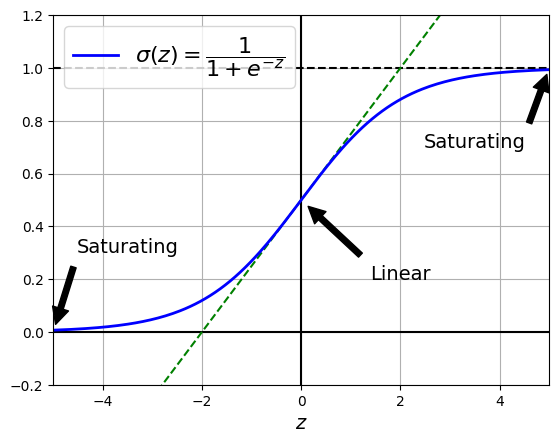

In [7]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

### 1. Inicializações de Glorot (Xavier) e He: mantendo o “fluxo de sinal”

**Objetivo:** fazer o **sinal fluir bem** nas duas direções — **forward** (predição) e **backward** (gradientes) — **sem morrer** (*vanish*) nem **explodir**. A ideia central é que, em cada camada, a **variância da saída** seja **próxima** da **variância da entrada**, e que os **gradientes** mantenham **variância semelhante** antes/depois de atravessar a camada.

Como isso é impossível de garantir exatamente quando **fan-in** $\neq$ **fan-out** (onde **fan-in** = nº de entradas da camada e **fan-out** = nº de saídas), **Glorot & Bengio** propuseram um **compromisso prático** (Eq. 11-1), hoje chamado **Xavier/Glorot initialization**, usando a média $,\text{fanavg}=(\text{fanin}+\text{fanout})/2,$.

### Quem usa o quê? (visão geral)

* **Xavier/Glorot** — bom para **None/tanh/sigmoid/softmax**
  Variância (Normal): $\sigma^2=\dfrac{1}{\text{fanavg}}$.
* **Kaiming/He** — para **ReLU e variantes** (Leaky ReLU, ELU, GELU, Swish, Mish, SwiGLU, ReLU2)
  Variância (Normal): $\sigma^2=\dfrac{2}{\text{fanin}}$.
* **Yann LeCun** — para **SELU**
  Variância (Normal): $\sigma^2=\dfrac{1}{\text{fanin}}$.

> **Uniforme vs. Normal:** para a **distribuição uniforme** $U(-a,a)$ com a mesma variância $\sigma^2$, use
> $a=\sqrt{3},\sigma$ (pois $\mathrm{Var}[U(-a,a)]=a^2/3$).

**Notas históricas:** a **inicialização de LeCun** (anos 1990) é equivalente à de Glorot quando $\text{fanin}=\text{fanout}$. O uso de **Glorot** acelerou o treino e foi decisivo para o sucesso de redes profundas.

### Observação sobre o `nn.Linear` do PyTorch

Por razões históricas, `nn.Linear` usa por padrão uma **variante “Kaiming uniform”** com **escala não ideal** para ativações comuns (e o **bias** também é inicializado aleatoriamente). Um ajuste simples é **re-escalar os pesos logo após criar a camada** (e **zerar o bias**). Por exemplo, multiplicar por $\sqrt{6}$ (isto é, $6^{0{,}5}$) para corrigir a escala e depois definir o **viés em zero**.

> **Resumo prático:**
>
> * **Escolha a inicialização** de acordo com a **função de ativação** da camada.
> * **Xavier/Glorot** (None/tanh/sigmoid), **He/Kaiming** (ReLU-like), **LeCun** (SELU).
> * **Uniforme**: use $a=\sqrt{3},\sigma$.
> * No PyTorch, considere **ajustar a escala** do `nn.Linear` e **zerar biases** ao construir o modelo.


In [8]:
import torch
import torch.nn as nn

layer = nn.Linear(40, 10)
layer.weight.data *= 6 ** 0.5  # Kaiming init (or 3 ** 0.5 for LeCun init)
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Criamos uma camada `Linear` com 40 neurônios de entrada e 10 neurônios de saída.

- Multiplicar os pesos por √6 segue a lógica da inicialização **Kaiming**, que ajusta a variância dos pesos para manter os gradientes estáveis ao longo da rede, especialmente útil para funções **ReLU**.  
- Para funções de ativação como **sigmoid** ou **tanh**, usaríamos √3, seguindo a inicialização de **LeCun**, que é otimizada para essas ativações.  
- Zeramos os **biases**, pois eles não necessitam de valores aleatórios e ajudam a manter a rede estável no início do treinamento.

O resultado de `layer.bias.data` é um tensor de zeros, mostrando que todos os bias foram inicializados corretamente.

> Essa abordagem é manual, mas útil para entender o que acontece “por trás das câmeras” quando usamos inicializações automáticas.


### 2. Inicialização usando funções do PyTorch (nn.init)

In [9]:
layer = nn.Linear(40, 10)
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

Aqui usamos funções de inicialização já prontas do PyTorch:

- `nn.init.kaiming_uniform_` cria pesos de forma que a variação do sinal se mantenha estável após passar pela camada, ideal para **ReLU** e variantes.  
- `nn.init.zeros_` zera os **bias** de maneira simples e direta.

> Esse método elimina a necessidade de calcular manualmente o fator de multiplicação e é mais seguro, principalmente quando lidamos com redes maiores.

O PyTorch possui várias funções de inicialização (`normal_`, `uniform_`, `xavier_uniform_`, `kaiming_normal_`, etc.), cada uma adaptada para diferentes funções de ativação e situações.


### 3. Inicialização automática para modelos completos com `apply()`


In [10]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

model = nn.Sequential(nn.Linear(50, 40),
                      nn.ReLU(),
                      nn.Linear(40, 1),
                      nn.ReLU())
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=1, bias=True)
  (3): ReLU()
)

Este bloco demonstra uma forma mais elegante e escalável de inicializar pesos:

- Criamos a função `use_he_init`, que verifica se o módulo é uma camada `Linear` (`nn.Linear`) e aplica a inicialização de **Kaiming** nos pesos e zeros nos **bias**.  
- Com `nn.Sequential`, definimos um modelo com duas camadas lineares e **ReLU** entre elas.  
- O comando `model.apply(use_he_init)` percorre todas as camadas do modelo e aplica a inicialização apenas nas camadas lineares.  

> Essa abordagem é muito prática para modelos grandes, pois evita a repetição de código e garante que todas as camadas lineares sejam inicializadas corretamente.  

Dessa forma, a rede começa o treinamento com pesos que mantêm os gradientes equilibrados e reduzem problemas de **explosão** ou **desaparecimento** de gradientes.
  

### 4. Inicialização para LeakyReLU

In [11]:
model = nn.Sequential(nn.Linear(50, 40),
                      nn.LeakyReLU(negative_slope=0.2))
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
)

- Criamos uma camada `Linear` seguida de **LeakyReLU**, uma variante da ReLU que permite que pequenos gradientes passem mesmo quando o neurônio não está ativado.  
- Reaplicamos a função `use_he_init` para inicializar corretamente os pesos da camada `Linear`, garantindo que a variação do sinal permaneça estável mesmo com a **LeakyReLU**.  
- Inicializações como **Kaiming** são pensadas levando em consideração a função de ativação usada, evitando que gradientes desapareçam em redes profundas.  

> Esse padrão de inicialização é uma boa prática em redes profundas, independentemente de termos uma única camada ou várias camadas com diferentes funções de ativação.


# Resumindo:

# Vanishing & Exploding Gradients

## O que são?

Durante o treinamento, o gradiente precisa atravessar muitas camadas na backpropagation.
Como cada camada adiciona **multiplicações** (derivadas das ativações + pesos), o gradiente pode:

* **Diminuir exageradamente** → *Vanishing Gradient*
* **Aumentar exageradamente** → *Exploding Gradient*

Isso ocorre porque:

$
\nabla W^{(1)} = D^{(L)} W^{(L)} \cdots D^{(2)} W^{(2)}
$

Se os fatores forem < 1 → resultado → 0
Se forem > 1 → resultado → ∞


## Consequências

### Vanishing Gradient

* As primeiras camadas **não aprendem**
* Treinamento lento
* Comum com **sigmoid/tanh** saturadas

### Exploding Gradient

* Pesos ficam enormes
* Loss vira `nan`
* Treinamento instável
* Frequente em redes profundas e RNNs


## Como resolver:

### ✔ Inicializações adequadas

* **Glorot/Xavier** → sigmoid/tanh
* **He/Kaiming** → ReLU/LeakyReLU/ELU

### ✔ Funções de ativação modernas

* **ReLU**, **LeakyReLU**, **ELU**, **SELU** (menos saturação)

### ✔ Normalização

* **Batch Normalization**
* **Layer Normalization**

### ✔ Gradient Clipping

```python
nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
```

---

# Exemplo: Vanishing & Exploding Gradient na Prática

## 1. MLP com Sigmoid (provoca *vanishing gradient*)

→ Gradientes **extremamente pequenos** (ex.: `1e-6`, `1e-8`, etc.)



In [12]:
torch.manual_seed(42)

class BadMLP(nn.Module):
    def __init__(self):
        super().__init__()
        layers = []
        for _ in range(10):  # rede profunda
            layers.append(nn.Linear(100, 100))
            layers.append(nn.Sigmoid())  # causa vanish
        layers.append(nn.Linear(100, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = BadMLP()
x = torch.randn(32, 100)
y = torch.randn(32, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

loss = criterion(model(x), y)
loss.backward()

# medir tamanho médio dos gradientes
mean_grad = torch.mean(torch.stack([
    p.grad.abs().mean() for p in model.parameters() if p.grad is not None
]))

grads = []
for name, p in model.named_parameters():
    if p.grad is not None and "weight" in name:
        grads.append((name, p.grad.abs().mean().item()))

grads

[('net.0.weight', 7.093833159776963e-11),
 ('net.2.weight', 1.2001527549543312e-09),
 ('net.4.weight', 7.099061782867011e-09),
 ('net.6.weight', 5.384061196878065e-08),
 ('net.8.weight', 3.450975327723427e-07),
 ('net.10.weight', 2.0940392460033763e-06),
 ('net.12.weight', 1.7149863197118975e-05),
 ('net.14.weight', 0.00011907377484021708),
 ('net.16.weight', 0.0007421850459650159),
 ('net.18.weight', 0.006597514264285564),
 ('net.20.weight', 0.5547868609428406)]

1. **Quanto mais fundo (mais perto da entrada), menor o gradiente.**
   Isso é exatamente o que a teoria diz: na backprop, o gradiente da primeira camada é o produto de muitas derivadas pequenas (sigmoid saturando + pesos), e ele **vai encolhendo exponencialmente**.

2. **As primeiras camadas praticamente não aprendem.**
   Com gradiente na ordem de `1e-11`, a atualização de peso é tão pequena que, na prática, é quase como se essas camadas estivessem **congeladas**.
   Ou seja: a rede é “profunda” no papel, mas **rasa na prática**, porque só as últimas camadas mudam de verdade.

3. **Isso é o “vanishing gradient ao longo da profundidade”.**
   Importante:

   * não é que “o gradiente total sumiu do modelo” (a última camada tem gradiente grande),
   * é que **ao voltar pela rede**, as camadas anteriores recebem cada vez menos sinal.

4. **Não é explosão de gradiente.**

   * Não vemos nada na ordem de 1e+3, 1e+4 etc.
   * O problema aqui é claramente de **desaparecimento**, não de explosão.


#  Exploding Gradient — Demonstração e Solução

## O problema

Exploding gradient acontece quando, durante a backpropagation, os gradientes ficam **muito grandes**, geralmente porque:

* os pesos têm valores altos,
* a rede é muito profunda,
* a função de ativação mantém valores grandes ao longo das camadas,
* não há mecanismos de estabilização.

Isso causa:

* perda (`loss`) instável,
* pesos explodindo,
* `nan` durante o treinamento.

---

#  1. Demonstração do Exploding Gradient

Vamos criar uma MLP profunda com pesos **artificialmente inflados** para provocar a explosão.

### 🔍 O que você deve ver:

* Os gradientes das camadas finais podem estar **entre 10 e 10.000**
* Algumas camadas podem até retornar `inf` ou `nan`
* A explosão cresce **exponencialmente** ao voltar na rede

É o oposto do vanishing gradient.

---

#  2. Como resolver a explosão de gradiente

Existem várias técnicas modernas. Aqui vamos demonstrar as três principais:

In [13]:
import torch
import torch.nn as nn

torch.manual_seed(42)

class ExplodingMLP(nn.Module):
    def __init__(self):
        super().__init__()
        layers = []
        for _ in range(10):   # 10 camadas profundas
            lin = nn.Linear(100, 100)
            lin.weight.data *= 10   # PESOS GIGANTES → causam explosão
            layers.append(lin)
            layers.append(nn.ReLU())
        layers.append(nn.Linear(100, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = ExplodingMLP()
x = torch.randn(32, 100)
y = torch.randn(32, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

loss = criterion(model(x), y)
loss.backward()

# Gradiente por camada
grads = []
for name, p in model.named_parameters():
    if p.grad is not None and "weight" in name:
        grads.append((name, p.grad.abs().mean().item()))

grads

[('net.0.weight', 7738972160.0),
 ('net.2.weight', 9784254464.0),
 ('net.4.weight', 9721781248.0),
 ('net.6.weight', 10572561408.0),
 ('net.8.weight', 10231172096.0),
 ('net.10.weight', 12592165888.0),
 ('net.12.weight', 14098934784.0),
 ('net.14.weight', 14176247808.0),
 ('net.16.weight', 12550867968.0),
 ('net.18.weight', 12300710912.0),
 ('net.20.weight', 1895198097408.0)]

## A) Gradient Clipping

```python
nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
```

Isso limita o valor máximo do gradiente. Simples e extremamente útil, especialmente em RNNs e modelos profundos.

---

## B) Inicialização adequada (He/Kaiming)

```python
lin = nn.Linear(100, 100)
nn.init.kaiming_normal_(lin.weight, nonlinearity="relu")
```

Mantém a variância estável ao longo das camadas → impede amplificação explosiva dos valores.

---

## C) Normalização (BatchNorm / LayerNorm)

```python
nn.BatchNorm1d(100)
```

Controla a escala das ativações → impede valores grandes demais.

---

# 3. Demonstração da Solução (versão estável)

Aqui está uma rede equivalente, mas com todas as correções aplicadas.

### Resultado esperado:

* Todos os gradientes devem ficar entre **0.01 e 0.5**
* Nada explode
* Rede treina de forma estável


In [14]:
class StableMLP(nn.Module):
    def __init__(self):
        super().__init__()
        layers = []
        for _ in range(10):
            lin = nn.Linear(100, 100)
            nn.init.kaiming_normal_(lin.weight, nonlinearity="relu")  # inicialização OK
            layers.append(lin)
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(100))   # estabiliza ativações
        layers.append(nn.Linear(100, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = StableMLP()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

loss = criterion(model(x), y)
loss.backward()

# Aplicando gradient clipping
nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

grads_stable = []
for name, p in model.named_parameters():
    if p.grad is not None and "weight" in name:
        grads_stable.append((name, p.grad.abs().mean().item()))

grads_stable

[('net.0.weight', 0.004559306427836418),
 ('net.2.weight', 0.004819301888346672),
 ('net.3.weight', 0.0035388728138059378),
 ('net.5.weight', 0.0035948199220001698),
 ('net.6.weight', 0.002689970890060067),
 ('net.8.weight', 0.00311879045329988),
 ('net.9.weight', 0.0021293514873832464),
 ('net.11.weight', 0.00248133298009634),
 ('net.12.weight', 0.0017054439522325993),
 ('net.14.weight', 0.001972188940271735),
 ('net.15.weight', 0.00135030597448349),
 ('net.17.weight', 0.001555218710564077),
 ('net.18.weight', 0.0009958642767742276),
 ('net.20.weight', 0.0011424899566918612),
 ('net.21.weight', 0.0007621159893460572),
 ('net.23.weight', 0.0009918655268847942),
 ('net.24.weight', 0.0005853312904946506),
 ('net.26.weight', 0.0008282719645649195),
 ('net.27.weight', 0.0004622996202670038),
 ('net.29.weight', 0.0006086648791097105),
 ('net.30.weight', 0.011864079162478447)]

# 🎯 Conclusão

* Exploding gradient → gradientes assumem valores enormes ao atravessar camadas.
* Provoca instabilidade, `nan`, training failure.
* Resolvemos com:

  * Gradient clipping
  * Inicialização adequada (He/Kaiming)
  * Normalização (BatchNorm / LayerNorm)

Esse bloco já é suficiente para uma célula explicativa + demo em aula. Quer que eu gere também um gráfico mostrando a explosão vs. estabilização para ilustrar no notebook?

# Better Activation Functions

## Funções de ativação melhores (além da sigmoide)

O trabalho de **Glorot & Bengio (2010)** mostrou que **ativação mal escolhida** contribui para **gradientes instáveis**. Em redes profundas, **ReLU** tende a funcionar melhor que a **sigmoide** por **não saturar para valores positivos** e por ser **rápida** de computar.

### O problema das “ReLUs mortas”

A **ReLU** não é perfeita: pode ocorrer o fenômeno das **ReLUs mortas**. Durante o treino, alguns neurônios passam a **produzir sempre $0$** porque sua entrada (soma ponderada + viés) fica **negativa para todas as instâncias**; como o **gradiente da ReLU é $0$** quando a entrada é negativa, **esses neurônios deixam de atualizar**. Isso é mais comum com **taxas de aprendizado altas**.

## Leaky ReLU (e variantes)

**Definição:**

$\mathrm{LeakyReLU}_{\alpha}(z)=\max(\alpha z, z)$

O **hiperparâmetro** $,\alpha,$ controla o **“vazamento”** para $,z<0,$ (inclinação não nula). Com isso, neurônios **não morrem de vez**: podem “entrar em coma”, mas ainda **recebem gradiente**.

**Achados empíricos (Xu et al., 2015):**

* **Leaky ReLU** superou a ReLU “estrita” em vários cenários.
* Um **vazamento grande** ($\alpha=0{,}2$) rendeu melhor desempenho do que **vazamento pequeno** ($\alpha=0{,}01$) em seus testes.
* **RReLU** (*Randomized Leaky ReLU*): escolhe $,\alpha,$ **aleatoriamente** em um intervalo no treino e fixa na **média** no teste; atuou como **regularizador**, reduzindo **overfitting**.
* **PReLU** (*Parametric Leaky ReLU*): torna $,\alpha,$ um **parâmetro treinável** (ajustado por backprop). Reportou **forte ganho** sobre ReLU em **grandes bases de imagens**, mas em **datasets pequenos** pode **superajustar**.


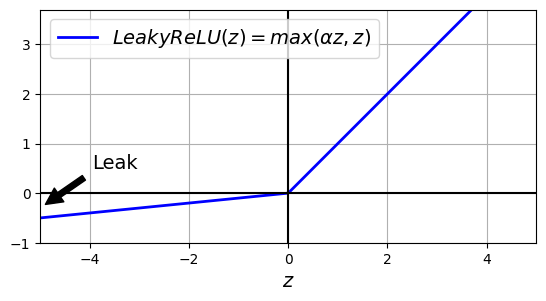

In [15]:
# extra code – this cell generates Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

O PyTorch oferece módulos para essas variantes: **`nn.LeakyReLU`**, **`nn.RReLU`** e **`nn.PReLU`**. Assim como nas outras variantes de ReLU, use **inicialização de Kaiming (He)**, **ajustada** para o **declive negativo** $\alpha$:

* A **variância** deve ser **menor** que a da ReLU “pura”, **escalada por** $,1+\alpha^2,$ (ou seja, efetivamente dividida por $,1+\alpha^2$).
* O PyTorch já dá suporte a esse ajuste: nas funções de inicialização **`kaiming_uniform_()`** ou **`kaiming_normal_()`**, passe o **hiperparâmetro** $\alpha$ e `nonlinearity="leaky_relu"` para obter a **Kaiming correta para Leaky ReLU**.


In [16]:
torch.manual_seed(42)
alpha = 0.2
model = nn.Sequential(nn.Linear(50, 40),
                      nn.LeakyReLU(negative_slope=alpha))
nn.init.kaiming_uniform_(model[0].weight, alpha, nonlinearity="leaky_relu")
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

### ELU

Implementar **ELU** em PyTorch é trivial: basta adicionar uma camada `ELU` após cada camada `Linear` em seu modelo e certificar-se de usar a **inicialização de Kaiming** para essas camadas `Linear`.



In [17]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40),
                      nn.ELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

### SELU

## Função de Ativação SELU

Por padrão, os hiperparâmetros da **SELU** (escala e alfa) são ajustados para que:

- 🟢 A **saída média** de cada neurônio permaneça próxima de **0**  
- 🔵 O **desvio padrão** permaneça próximo de **1**  

> Observação: isso assume que as entradas também sejam padronizadas com média 0 e desvio padrão 1, e que outras restrições sejam respeitadas (conforme explicado no livro).

### Benefícios da SELU em redes profundas

- Mesmo em uma rede com **1.000 camadas**, a média e o desvio padrão são aproximadamente mantidos em todas as camadas.  
- Evita problemas de **explosão ou desaparecimento de gradientes**, garantindo estabilidade durante o treinamento.  
- Facilita o aprendizado profundo sem necessidade de normalização adicional (como BatchNorm), em muitas situações.

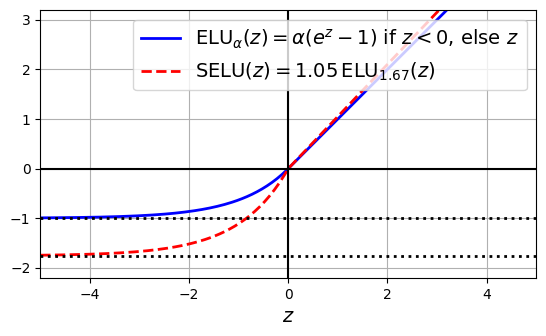

In [18]:
# extra code – this cell generates Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

Using SELU is straightforward:

In [19]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.SELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

# Camada Linear com SELU e Inicialização Kaiming

Este código demonstra como construir uma **camada Linear** seguida da função de ativação **SELU** e inicializar os pesos de forma apropriada para redes MLP profundas.

- Primeiro, definimos uma **semente aleatória** (`torch.manual_seed(42)`) para garantir **reprodutibilidade**, de forma que as inicializações e os resultados sejam consistentes entre execuções.

- Em seguida, construímos um **modelo sequencial** com:
  - Uma camada `Linear` de 50 entradas e 40 saídas  
  - Ativação **SELU**  

> A SELU é uma versão escalada da ELU, projetada para **auto-normalizar** a saída da camada, mantendo média próxima de 0 e desvio padrão próximo de 1. Isso ajuda a evitar problemas clássicos de redes profundas, como gradientes que desaparecem ou explodem.

- Para preparar o modelo para **treinamento eficiente**, os pesos da camada `Linear` são inicializados com a **Kaiming uniform**, compatível com funções de ativação lineares e não lineares, como a SELU.  
  - Essa inicialização ajusta a variância dos pesos para que os gradientes se mantenham estáveis durante o **forward** e o **backward pass**.

- Por fim, o modelo é testado com uma entrada aleatória de dimensão `(2, 50)`.  
  - A saída resultante tem dimensão `(2, 40)`, confirmando que a camada Linear foi criada corretamente e que o **forward pass** funciona como esperado.


### GELU, Swish, SwiGLU, Mish, and ReLU²

#  Visualização de Funções de Ativação Modernas

Neste bloco, vamos visualizar algumas das **funções de ativação modernas** mais utilizadas em redes profundas, além das funções tradicionais como **ReLU** e suas variantes.

O código plota graficamente as funções:

- **GELU**  
- **Swish**  
- **Swish com beta ajustado**  
- **Mish**  
- **ReLU²**

## Objetivos da Visualização

- Compreender visualmente como cada função transforma **entradas negativas e positivas**.  
- Observar o efeito da **suavidade** ou **inclinação** em entradas negativas sobre os gradientes.  
- Identificar diferenças importantes em termos de **saturação**, **continuidade** e **expressividade**.

> Ao observar essas curvas, podemos decidir qual função é mais adequada para diferentes tipos de redes profundas, considerando **estabilidade**, **aprendizado** e **desempenho**.


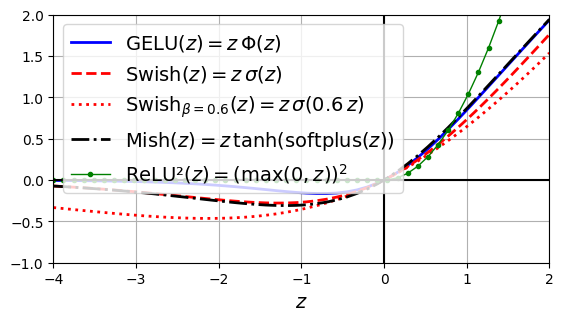

In [20]:
# extra code – this cell generates Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

def relu_squared(z):
    return np.maximum(0, z)**2

z = np.linspace(-4, 2, 50)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "k-.", linewidth=2,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot(z, relu_squared(z), "g.-", linewidth=1,
         label=fr"ReLU²$(z) = (\max(0, z))^2$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()

# Comparação de Funções de Ativação

O gráfico permite **comparar visualmente** o comportamento das funções de ativação:

- **GELU** e **Swish**  
  - Apresentam **suavidade em valores negativos**, permitindo gradientes pequenos mas não nulos  
  - Isso ajuda na aprendizagem de **redes profundas**

- **Swish com beta ajustado**  
  - Mostra como o **hiperparâmetro β** altera a inclinação  
  - Controla a **suavidade para entradas negativas**

- **Mish**  
  - Combina **suavidade** e **gradientes não nulos**  
  - Mantém **continuidade e estabilidade**

- **ReLU²**  
  - Reforça os **valores positivos**  
  - Mantém **zero para negativos**, aumentando a sensibilidade para sinais positivos

> Essa visualização evidencia que funções de ativação modernas oferecem **vantagens sobre a ReLU simples**, principalmente em **redes profundas ou complexas**, onde a **propagação de gradientes estáveis** é essencial para o treinamento eficiente.


# Função de Ativação SwiGLU

Neste trecho, apresentamos a função de ativação **SwiGLU**, uma variante moderna das funções **lineares-gateadas** (GLU – Gated Linear Units).  

- **SwiGLU** combina a função **Swish** com um **mecanismo de gate**, permitindo que parte da entrada controle dinamicamente a outra parte.  
- Isso aumenta a **capacidade expressiva** do modelo sem adicionar muitas camadas.

## Objetivos do Código

1. Demonstrar a criação de uma **classe customizada de ativação** no PyTorch usando `nn.Module`.  
2. Integrar essa ativação a uma **camada Linear**, mantendo a **inicialização de pesos adequada**.


In [21]:
class SwiGLU(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        z1, z2 = x.chunk(2, dim=-1)
        param_swish = z1 * torch.sigmoid(self.beta * z1)
        return param_swish * z2

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 2 * 40),
                      SwiGLU(beta=0.2))
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

# Funcionamento da Ativação SwiGLU

A ativação **SwiGLU** divide a saída da camada Linear em duas partes:

- **z1:**  
  - Passa pelo **Swish**  
  - Atua como um módulo de ativação, controlando a intensidade do sinal

- **z2:**  
  - Funciona como **gate**, modulando dinamicamente os valores ativados de z1

> Essa abordagem melhora a **capacidade expressiva** do modelo e permite capturar **interações complexas** entre features sem adicionar camadas extras.

##  Detalhes do Código

- A camada **Linear** foi dimensionada para **2×40 unidades**, pois SwiGLU divide a saída ao meio  
- A **inicialização Kaiming uniform** garante que os gradientes fluam de forma estável  
- Passando uma entrada aleatória de dimensão `(2, 50)`, a saída tem dimensão `(2, 40)`, confirmando que a divisão e o gate foram aplicados corretamente

> Essa construção mostra como funções de ativação modernas e **mecanismos de gate** podem ser integrados de forma simples, mas poderosa, em **redes profundas**, especialmente em modelos como **Transformers** e **MLPs de larga escala**.


**ReLU<sup>2</sup>**

# Função de Ativação ReLU²

Neste bloco, implementamos a função de ativação **ReLU²**, uma variação simples da **ReLU clássica** que:

- Eleva ao **quadrado os valores positivos**  
- Mantém **zero para os negativos**

## Objetivos da Função

1. **Aumentar a sensibilidade** para entradas positivas, reforçando a ativação de neurônios com sinais fortes  
2. **Manter gradientes nulos** para entradas negativas, preservando a característica de **sparsidade** da ReLU tradicional  
3. **Integrar facilmente** como uma **classe customizada** no PyTorch, permitindo seu uso em **redes sequenciais**


In [22]:
import torch.nn.functional as F

class ReLU2(nn.Module):
    def forward(self, x):
        return F.relu(x).square()

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), ReLU2())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

# Funcionamento da Ativação ReLU²

A ativação **ReLU²** transforma os valores positivos da camada Linear **elevando-os ao quadrado**, reforçando sinais fortes e mantendo **zeros para entradas negativas**.

## Detalhes do Código

- Criamos a **classe ReLU²**, estendendo `nn.Module` e definindo o método `forward`  
- A camada **Linear** possui **50 entradas e 40 saídas**, com **inicialização Kaiming uniform**, garantindo estabilidade nos gradientes  
- Passando uma **entrada aleatória** de dimensão `(2, 50)`, a saída tem dimensão `(2, 40)`, confirmando que a ativação foi aplicada corretamente

> Essa função é útil em cenários onde queremos **realçar sinais positivos** sem comprometer a eficiência do treinamento, mantendo a simplicidade da **ReLU tradicional**.


#  Batch Normalization (BN)

Mesmo utilizando a **inicialização Kaiming** juntamente com a **ReLU** (ou suas variantes), que ajuda a reduzir problemas de gradientes desaparecendo ou explodindo no início do treinamento, isso **não garante** que esses problemas não retornem durante o treinamento de redes profundas.

Para contornar essa questão, **Sergey Ioffe** e **Christian Szegedy** propuseram, em 2015, a técnica de **Batch Normalization (BN)**.  

Essa técnica adiciona uma operação na rede, geralmente **antes ou depois da função de ativação** de cada camada oculta.

## Funcionamento da BN

1. **Normalização do mini-batch:**  
   - Cada entrada da camada é **zero-centralizada** e **normalizada**, utilizando a **média** e o **desvio padrão** do mini-batch atual.

2. **Escala e deslocamento:**  
   - A saída é escalada e deslocada por dois vetores de **parâmetros aprendíveis**:  
     - **γ (gamma):** controle da escala  
     - **β (beta):** controle do deslocamento

> Dessa forma, a rede pode aprender a melhor média e escala para cada entrada, mantendo os **gradientes estáveis** e facilitando o treinamento.

##  Benefícios Adicionais

- Se uma camada BN for adicionada como **primeira camada da rede**, **não é necessário padronizar o conjunto de dados de entrada**, pois a BN realiza a normalização automaticamente (aproximadamente, considerando apenas o mini-batch corrente).  
- Permite ajustar cada feature individualmente com os parâmetros aprendíveis.

> O algoritmo precisa estimar a **média** e o **desvio padrão** de cada entrada usando os dados do mini-batch, motivo pelo qual recebeu o nome de **Batch Normalization**.

> A operação completa, detalhando cada passo da normalização, é apresentada na **equação 11-4**, que resume o algoritmo de Batch Normalization.


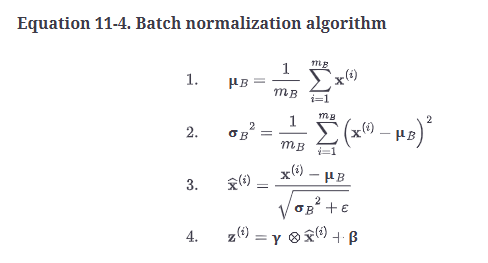

# Funcionamento Detalhado da Batch Normalization (BN)

A **Batch Normalization (BN)** padroniza e ajusta os inputs de cada camada oculta para melhorar a **estabilidade** e acelerar o treinamento.  

Vamos detalhar os elementos do algoritmo:

- **μB:** vetor das médias dos inputs, calculadas sobre todo o mini-batch B (uma média por input).  
- **mB:** número de instâncias no mini-batch.  
- **x(i):** vetor de entrada da camada BN para a instância i.  
- **σB:** vetor das variâncias (ou desvios padrão) dos inputs, calculadas sobre o mini-batch.  
- **(i):** vetor de inputs zero-centralizados e normalizados para a instância i.  
- **ε:** pequeno número para evitar divisão por zero e controlar o crescimento dos gradientes (tipicamente 10⁻⁵).  
- **γ (gamma):** vetor de parâmetros aprendíveis de escala para cada input.  
- **β (beta):** vetor de parâmetros aprendíveis de deslocamento para cada input.  
- **⊗:** multiplicação elemento a elemento.  
- **z(i):** saída da operação BN, obtida após normalização, escala e deslocamento.

Durante o treinamento, a BN normaliza cada input com base nas estatísticas do mini-batch e depois aplica a **escala** e **deslocamento aprendíveis**.

##  Uso da BN em Teste

No teste, muitas vezes precisamos fazer previsões para **instâncias individuais**, sem mini-batch. Nesse caso, não há como calcular média e desvio padrão de cada input diretamente.

**Soluções comuns:**

1. Rodar toda a base de treinamento no modelo treinado e calcular a média e variância de cada input para uso no teste.  
2. Estimativa em tempo de treinamento usando uma **média móvel exponencial** das médias e variâncias do mini-batch (como implementado em `nn.BatchNorm1d` do PyTorch).

Portanto, cada camada BN aprende **quatro vetores de parâmetros**:

- **γ e β:** aprendidos via backpropagation.  
- **μ (média final) e σ² (variância final):** estimados com média móvel durante o treinamento e usados somente em avaliação (`model.eval()`).

##  Benefícios Observados

Ioffe e Szegedy demonstraram que a BN:

- Melhorou significativamente redes profundas em tarefas como **classificação de imagens no ImageNet**.  
- Reduziu fortemente o problema de **gradientes desaparecendo**, permitindo o uso de funções de ativação saturantes como tanh e sigmoid.  
- Tornou a rede menos sensível à **inicialização de pesos**.  
- Permitiu **taxas de aprendizado maiores**, acelerando o treinamento.  
- Atuou como um **regularizador**, diminuindo a necessidade de outras técnicas como dropout.

**Resultados impressionantes incluem:**

- Mesma precisão com **14 vezes menos iterações de treinamento**.  
- Uso de **ensemble de redes BN** melhorou resultados no ImageNet, atingindo 4,9% de erro top-5 na validação, superando humanos em algumas métricas.


##  Considerações e Otimizações

- A BN adiciona **complexidade** ao modelo e pode gerar **penalidade de tempo de execução**, pois cada camada realiza cálculos extras.  
- Uma otimização possível é **fundir a camada BN com a camada anterior** após o treinamento.

Se a camada anterior calcula:


$X W + b$


e a BN calcula:

$
z = \gamma \otimes \frac{(X W + b - \mu)}{\sigma} + \beta
$

Podemos definir:

$
W' = \gamma \otimes \frac{W}{\sigma}, \quad b' = \gamma \otimes \frac{(b - \mu)}{\sigma} + \beta
$

e substituir $W$ e $b$ por $W'$ e $b'$, **eliminando a BN durante a inferência**.

> Essa técnica é utilizada, por exemplo, em `optimize_for_inference()` para acelerar a previsão.


# MLP Profunda com Batch Normalization no PyTorch

Este bloco de código mostra como construir uma **rede neural MLP profunda** utilizando **Batch Normalization (BN)** em PyTorch.  

A BN é aplicada:

- Após a **camada de entrada**  
- Entre as **camadas lineares** e suas ativações **ReLU**  

Isso ajuda a **manter os gradientes estáveis** durante o treinamento e acelera a **convergência**.

---

## Estrutura da Rede

1. **Flatten**:  
   - Transforma a entrada 2D do MNIST (28x28) em um vetor 1D de 784 elementos.  

2. **BatchNorm1d**:  
   - Normaliza os inputs da primeira camada linear, garantindo média próxima de 0 e desvio padrão próximo de 1.  

3. **Linear + ReLU + BatchNorm1d**:  
   - Camadas ocultas intercaladas com **BN** para estabilizar o treinamento e acelerar a convergência.  

4. **Linear final**:  
   - Gera os **10 outputs**, correspondentes às classes do MNIST.


In [ ]:
torch.manual_seed(42) # Para reprodutibilidade

model = nn.Sequential( # Modelo MLP estável com BatchNorm e ReLU
    nn.Flatten(), # achata a entrada
    nn.BatchNorm1d(1 * 28 * 28), # aplica BatchNorm na entrada
    nn.Linear(1 * 28 * 28, 300), # primeira camada oculta
    nn.ReLU(), # ativações ReLU
    nn.BatchNorm1d(300), # normaliza a saída da primeira camada oculta
    nn.Linear(300, 100), # segunda camada oculta
    nn.ReLU(), # ativações ReLU
    nn.BatchNorm1d(100), # normaliza a saída da segunda camada oculta
    nn.Linear(100, 10) # camada de saída
)

## Benefícios da Batch Normalization nas Camadas Ocultas

Com esta configuração:

- Cada camada oculta aprende **parâmetros de escala e deslocamento (γ e β)**, além de normalizar suas entradas com base no **mini-batch**, garantindo que o **fluxo de gradientes** se mantenha estável.  

- Isso permite que a rede:
  - Treine **mais rápido**;  
  - Seja **menos sensível à inicialização de pesos**;  
  - Suporte **taxas de aprendizado maiores**, sem saturar as funções de ativação **ReLU**.  

- Durante a inferência, usando `model.eval()`, a BN aplica as **estatísticas acumuladas de média e desvio padrão**, garantindo **previsões consistentes** mesmo com batchs individuais.



##  Explorando Parâmetros Treináveis da Batch Normalization

O código a seguir permite explorar os **parâmetros treináveis** de uma camada específica da rede.  

No exemplo, `model[1]` é a primeira camada `BatchNorm1d`. Cada camada BN possui **parâmetros aprendíveis** que controlam a normalização:

- **γ (weight):** fator de escala aplicado após a normalização.  
- **β (bias):** deslocamento aplicado após a normalização.  

Ao inspecionar esses parâmetros, conseguimos entender quais elementos a rede pode ajustar via **backpropagation** para otimizar o desempenho durante o treinamento.


In [ ]:
dict(model[1].named_parameters()).keys() # parâmetros do BatchNorm na entrada

dict_keys(['weight', 'bias'])

##  Parâmetros Aprendíveis da BatchNorm1d

A `BatchNorm1d` aprende **apenas dois vetores** por camada:

- **γ (gamma) – Escala:**  
  Controla a amplitude dos valores após a normalização.

- **β (beta) – Deslocamento:**  
  Ajusta o ponto central (média) dos valores normalizados.

💡 **Importante:**  
Esses parâmetros permitem que a camada **modifique dinamicamente** a média e o desvio padrão das entradas, mantendo os **gradientes estáveis** e acelerando a **convergência do treinamento**.




##  Buffers Internos da BatchNorm1d

Além dos parâmetros aprendíveis (**weight** e **bias**), a `BatchNorm1d` mantém **buffers internos** que armazenam estatísticas usadas durante a avaliação (`model.eval()`).

- **O que são buffers?**  
  Valores fixos atualizados durante o treinamento, **não otimizados via backpropagation**.

- **Principais buffers da BN:**
  - **running_mean:** média acumulada das entradas da camada durante o treinamento.  
  - **running_var:** variância acumulada das entradas da camada durante o treinamento.  

💡 **Importante:**  
Esses buffers permitem que a camada **normalize os inputs mesmo em batchs individuais**, garantindo previsões consistentes na inferência.


In [25]:
dict(model[1].named_buffers()).keys()

dict_keys(['running_mean', 'running_var', 'num_batches_tracked'])

## Observações sobre a BatchNorm1d em Avaliação

 **Uso das estatísticas armazenadas:**  
A camada armazena **médias e variâncias do treinamento** para uso posterior durante a avaliação (`model.eval()`), garantindo que a normalização seja consistente mesmo em batchs individuais.

 **Boas práticas:**
- Aplicar a **BatchNorm1d antes da função de ativação** costuma apresentar melhor desempenho.
- A camada **Linear anterior** à BN **não precisa de bias**, pois a BN já possui parâmetros de deslocamento.  
  - Exemplo: `nn.Linear(in_features, out_features, bias=False)`


In [26]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 300, bias=False),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Linear(300, 100, bias=False),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

## Layer Normalization

## Exemplo de Layer Normalization em PyTorch

Este exemplo demonstra como aplicar **Layer Normalization (LayerNorm)**, uma técnica diferente da **Batch Normalization (BN)**:

- **BatchNorm:** normaliza os inputs com base no mini-batch.  
- **LayerNorm:** normaliza cada **amostra individualmente**, considerando todas as dimensões da instância.

### Exemplo:

- `inputs` é um batch de imagens RGB: `(32, 3, 100, 200)`  
  (32 imagens, 3 canais, 100x200 pixels)

- `nn.LayerNorm([100, 200])` cria uma camada que normaliza **os pixels de cada imagem**, garantindo média zero e desvio padrão 1 **por amostra**, sem depender das outras imagens do batch.

 **Aplicações comuns:**  
RNNs, Transformers e MLPs profundas, onde a dependência do mini-batch pode prejudicar a estabilidade do treinamento.


In [27]:
torch.manual_seed(42)

inputs = torch.randn(32, 3, 100, 200)  # a batch of random RGB images
layer_norm = nn.LayerNorm([100, 200])
result = layer_norm(inputs)  # normalizes over the last two dimensions

O resultado `result` possui as mesmas dimensões que `inputs`, mas **cada imagem foi normalizada independentemente**.

- Cada canal e pixel agora têm **média zero** e **desvio padrão 1** ao longo das dimensões `[100, 200]`.  
- A **LayerNorm** aprende dois parâmetros por canal:
  - **Escala (γ)**
  - **Deslocamento (β)**

Esses parâmetros permitem que a rede **ajuste a normalização de forma ótima** durante o treinamento.

💡 **Diferença principal em relação à BatchNorm:**
- **Não depende do tamanho do batch**
- Funciona de maneira consistente mesmo com **batchs unitários**
- Ideal para **modelos sequenciais** e arquiteturas com **entradas variáveis**.


Neste exemplo, mostramos como a **LayerNorm** funciona “por baixo dos panos”, replicando manualmente o que a camada `nn.LayerNorm` faz.

A LayerNorm **normaliza cada instância** subtraindo a média e dividindo pelo desvio padrão ao longo das dimensões especificadas.

No código:



In [28]:
means = inputs.mean(dim=[2, 3], keepdim=True)  # Calcula a média de cada imagem
vars_ = inputs.var(dim=[2, 3], keepdim=True, unbiased=False) # Calcula a variância
stds = torch.sqrt(vars_ + layer_norm.eps)  # Calcula o desvio padrão (com eps para estabilidade)
result2 = layer_norm.weight * (inputs - means) / stds + layer_norm.bias  # Aplica escala (γ) e deslocamento (β)
assert torch.allclose(result, result2)

A afirmação `assert torch.allclose(result, result2)` confirma que o cálculo manual produz **os mesmos resultados** que `nn.LayerNorm`.

Isso evidencia que a **LayerNorm** realiza três passos principais:

1. **Zero-centering:** subtrai a média da instância.  
2. **Normalização:** divide pelo desvio padrão da instância, garantindo variância 1.  
3. **Escala e deslocamento aprendíveis:** multiplica por γ e soma β, permitindo que a rede ajuste a normalização.

Dessa forma, a LayerNorm **normaliza por instância**, mantendo estabilidade e consistência de gradientes, mesmo com batchs pequenos ou unitários — diferente da BatchNorm.


In [29]:
layer_norm = nn.LayerNorm([3, 100, 200])
result = layer_norm(inputs)  # normalizes over the last three dimensions

O resultado `result` mantém as mesmas dimensões que `inputs`, mas cada imagem foi **normalizada considerando todos os seus elementos** (3×100×200):

- A média e a variância são calculadas **para cada instância inteira**, não por canal ou por batch.  
- A LayerNorm aplica os **parâmetros aprendíveis** γ (escala) e β (deslocamento), permitindo que a rede ajuste a normalização de forma ótima.  

Isso garante **estabilidade de gradientes** e consistência mesmo com batchs pequenos ou unitários, sendo especialmente útil em **RNNs, Transformers** e outras arquiteturas onde o batch não deve influenciar a normalização.


##Gradient Clipping

Uma técnica importante para **mitigar o problema de gradientes explodindo** é o **clipping de gradientes**, que limita os valores dos gradientes durante a retropropagação para que não ultrapassem um certo limiar.  

Essa técnica é especialmente útil em **redes neurais recorrentes (RNNs)**, onde o uso de **Batch Normalization** pode ser complicado.

---

### Implementação em PyTorch

No PyTorch, o clipping de gradientes pode ser feito usando:

- `torch.nn.utils.clip_grad_norm_()`
- `torch.nn.utils.clip_grad_value_()`

Estas funções devem ser chamadas **após o cálculo dos gradientes** (`loss.backward()`) e recebem como argumento principal a lista de parâmetros do modelo cujos gradientes serão limitados (`model.parameters()`).

#### `clip_grad_norm_()`
- Clipa o **norma do vetor gradiente** se ela exceder `max_norm`.
- Mantém a **orientação do vetor gradiente**.
- `max_norm` é um hiperparâmetro que você pode ajustar (valor típico: 1.0).

#### `clip_grad_value_()`
- Clipa **cada componente do vetor gradiente** entre `-clip_value` e `+clip_value`.
- Pode alterar a **direção do vetor gradiente**, mas ainda funciona bem na prática.
- `clip_value` é um hiperparâmetro ajustável.


### Exemplo de Loop de Treinamento com Clipping por Norma

```python
for epoch in range(n_epochs):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # clipping
        optimizer.step()
        optimizer.zero_grad()


## Reutilizando Camadas Pré-treinadas (Reusing Pretrained Layers)

Treinar uma **rede neural profunda (DNN)** muito grande do zero nem sempre é a melhor abordagem. Uma alternativa mais eficiente é utilizar **redes pré-treinadas** em tarefas semelhantes, técnica conhecida como **Transfer Learning**.

### Conceito
- **Transfer Learning** consiste em **reutilizar a maior parte das camadas** de uma rede existente, exceto as camadas superiores, que são específicas da tarefa original.
- Benefícios dessa abordagem:
  - **Reduz consideravelmente o tempo de treinamento**.
  - **Exige menos dados de treinamento**, já que a rede aproveita o conhecimento prévio.

### Exemplo Prático
- Suponha que você tenha uma DNN treinada para classificar **100 categorias de imagens**, incluindo animais, plantas, veículos e objetos do cotidiano.
- Agora você deseja treinar uma DNN para classificar **tipos específicos de veículos**.
- Como essas tarefas são **semelhantes e parcialmente sobrepostas**, faz sentido **reaproveitar partes da rede original** e ajustar apenas as camadas finais para a nova tarefa.

No diagrama ilustrativo (Figura 11-5), vemos como ocorre a reutilização das camadas:
- As **camadas inferiores** da rede original são **congeladas**, mantendo os pesos já aprendidos, que capturam **recursos genéricos** como bordas, texturas e formas.
- As **camadas superiores** são **treináveis**, permitindo que a rede se adapte às **novas categorias ou saídas específicas**.
- Dessa forma, a rede combina **conhecimento prévio** com **aprendizado específico** da nova tarefa, tornando o treinamento mais rápido e eficiente.









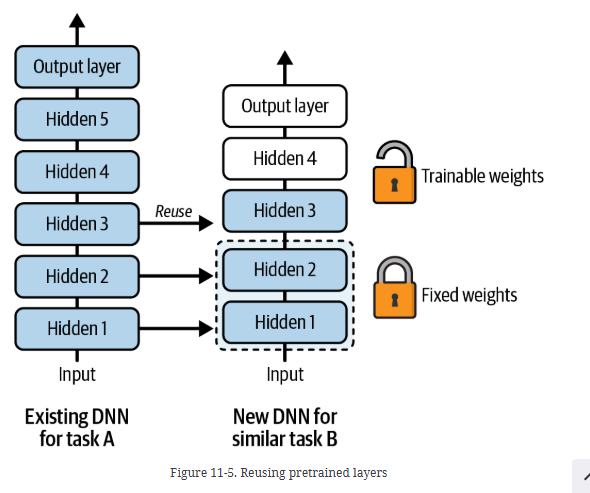

Ao reutilizar uma rede pré-treinada, **nem todas as camadas são igualmente úteis** para a nova tarefa. É importante decidir **quantas e quais camadas reaproveitar**.  

---

### 🔹 Camada de saída
- Geralmente deve ser **substituída**.  
- Motivos:  
  - Projetada para uma classificação diferente.  
  - Pode ter **número de saídas incompatível** com o novo problema.

---

### 🔹 Camadas ocultas superiores
- Menos reaproveitáveis.  
- Aprendem **características de alto nível** específicas da tarefa original.  
- Exemplo: Uma rede que distingue **animais** pode aprender padrões que não servem para classificar **veículos**.

---

### 🔹 Camadas inferiores
- Mais reaproveitáveis.  
- Capturam **características gerais**: bordas, texturas, formas.  
- Úteis para muitas tarefas diferentes.

---

###  Dica
- O desafio é **encontrar o número ideal de camadas a serem reutilizadas**:  
  - Aproveitar o máximo de conhecimento prévio.  
  - Garantir que a rede se adapte à **nova tarefa**.


## Transfer Learning with PyTorch

## 🔹 Dividindo o Conjunto de Treinamento MNIST Fashion

Vamos separar os dados em dois conjuntos distintos para treinar e testar a **Transferência de Aprendizado**.

### 1️⃣ Conjunto A (`X_train_A`)
- Inclui **todas as imagens de todas as classes**, **exceto**:  
  - **Camisetas/Blusas (classe 0)**  
  - **Pulôveres (classe 2)**  
- Objetivo: Treinar um modelo de **classificação com 8 classes**.

### 2️⃣ Conjunto B (`X_train_B`)
- Contém apenas as **20 primeiras imagens** das classes:  
  - **Camisetas/Blusas (classe 0)**  
  - **Pulôveres (classe 2)**  
- Objetivo: Testar **classificação binária** usando conhecimento transferido do Conjunto A.

### 3️⃣ Conjuntos de Validação e Teste
- Também divididos em **A** e **B**, mas **sem restrição no número de imagens**.

### 4️⃣ Estratégia de Transferência
- Treinar o modelo **no Conjunto A** (8 classes).  
- Reutilizar o modelo treinado para o **Conjunto B** (2 classes).  
- Expectativa: transferir **padrões aprendidos** do Conjunto A para melhorar a classificação do Conjunto B.

> ⚠️ Observação:  
> Como estamos usando **camadas Lineares**, apenas padrões que ocorrem **na mesma posição da imagem** podem ser reutilizados.  
> Para **camadas convolucionais**, a transferência é muito melhor, pois padrões aprendidos podem ser detectados em qualquer posição da imagem (ver Capítulo 12).

Vamos obter os dados do Fashion MNIST e dividi-los em conjuntos de dados A e B:


##  Preparação dos Conjuntos de Dados para Transfer Learning

Antes de aplicar **Transfer Learning**, precisamos organizar o dataset **Fashion MNIST**, que contém:

- **70.000 imagens** em tons de cinza (28×28 pixels)  
- **10 categorias de roupas**


###  Operações realizadas no código

1. **Carregar o dataset**
   - Utilizando `fetch_openml` para importar Fashion MNIST.

2. **Normalizar as imagens**
   - Dividindo os valores dos pixels por 255 para que fiquem no intervalo [0, 1].

3. **Criar dois subconjuntos de dados**
   - **Conjunto A:** todas as classes **exceto**  
     - T-shirt/top (classe 0)  
     - Pullover (classe 2)
   - **Conjunto B:** apenas as imagens das classes T-shirt/top e Pullover.

4. **Ajustar os rótulos (labels)**
   - Conjunto A: rótulos ajustados para faixa **0 a 7**.
   - Conjunto B: transformado em **classificação binária**:
     - 1 → T-shirt/top  
     - 0 → Pullover

5. **Divisão dos dados**
   - Criação de subconjuntos de **treinamento**, **validação** e **teste** para ambos os conjuntos A e B.

6. **Criar DataLoaders do PyTorch**
   - Facilita o carregamento em **batchs** durante o treinamento.


In [30]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="Fashion-MNIST", as_frame=False)
X = torch.FloatTensor(fashion_mnist.data.reshape(-1, 1, 28, 28) / 255.)
y = torch.from_numpy(fashion_mnist.target.astype(int))
in_B = (y == 0) | (y == 2)  # Pullover or T-shirt/top
X_A, y_A = X[~in_B], y[~in_B]
y_A = torch.maximum(y_A - 2, torch.tensor(0))  # [1,3,4,5,6,7,8,9] => [0,..,7]
X_B, y_B = X[in_B], (y[in_B] == 2).to(dtype=torch.float32).view(-1, 1)

train_set_A = TensorDataset(X_A[:-7_000], y_A[:-7000])
valid_set_A = TensorDataset(X_A[-7_000:-5000], y_A[-7000:-5000])
test_set_A = TensorDataset(X_A[-5_000:], y_A[-5000:])
train_set_B = TensorDataset(X_B[:20], y_B[:20])
valid_set_B = TensorDataset(X_B[20:5000], y_B[20:5000])
test_set_B = TensorDataset(X_B[5_000:], y_B[5000:])

train_loader_A = DataLoader(train_set_A, batch_size=32, shuffle=True)
valid_loader_A = DataLoader(valid_set_A, batch_size=32)
test_loader_A = DataLoader(test_set_A, batch_size=32)
train_loader_B = DataLoader(train_set_B, batch_size=32, shuffle=True)
valid_loader_B = DataLoader(valid_set_B, batch_size=32)
test_loader_B = DataLoader(test_set_B, batch_size=32)

##  Conjuntos Preparados para Transfer Learning

Após a preparação dos dados, temos:

- **Conjunto A**
  - Utilizado para treinar o **modelo base (Modelo A)**  
  - Contém todas as classes **exceto** T-shirt/top e Pullover  
  - Problema de classificação com **8 classes**

- **Conjunto B**
  - Utilizado posteriormente para testar o **aprendizado por transferência (Modelo B)**  
  - Contém apenas as classes T-shirt/top e Pullover  
  - Problema de **classificação binária**

Com isso, o **pipeline de dados** está pronto para os próximos passos do treinamento.


Vamos definir as funções `evaluate_tm()` e `train()`, de forma semelhante ao que fizemos no Capítulo 10:

In [31]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            # Uncomment to activate gradient clipping:
            #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

ModuleNotFoundError: No module named 'torchmetrics'

##Vamos definir nosso primeiro modelo para a tarefa A:

## Treinamento do Modelo A (Conjunto A)

Com os conjuntos de dados **A** e **B** preparados, o próximo passo é **definir e treinar o Modelo A**, responsável por classificar as **8 classes** do Conjunto A  
(todas as roupas, exceto T-shirts e Pullovers).

O modelo é uma **rede neural totalmente conectada (Feedforward MLP)** com múltiplas camadas lineares e ativações ReLU.

### Passo a Passo

1️⃣ **Reprodutibilidade**  
- `torch.manual_seed(42)` garante que os resultados possam ser **reproduzidos** em futuras execuções.

2️⃣ **Arquitetura do Modelo A**  
- **Entrada:** `28×28 pixels` → `nn.Flatten()` → vetor `1D [784]`  
- **Blocos ocultos (x3):**  
  - `nn.Linear(...)` → camada totalmente conectada  
  - `nn.ReLU()` → função de ativação não linear  
- **Saída:** `nn.Linear(100, 8)` → 8 saídas correspondentes às classes do Conjunto A  

3️⃣ **Envio do modelo para o dispositivo de processamento**  
- `model_A.to(device)` envia o modelo para **GPU** (se disponível) ou **CPU**, otimizando o desempenho do treinamento.

---

### Fluxo do Modelo

```text
[Input 28x28 pixels]
          │
        Flatten
          │
      [784] ──► Linear + ReLU
          │
      [100] ──► Linear + ReLU
          │
      [100] ──► Linear + ReLU
          │
      [100] ──► Linear (100 → 8)
          │
      [8 classes] ✅
          │
      [Enviado para GPU/CPU]
'

**Envio do modelo para o dispositivo de processamento**  
`model_A.to(device)`  

- Se uma **GPU** estiver disponível, o modelo será enviado para ela, garantindo **treinamento mais rápido**.  
- Caso contrário, o modelo permanecerá na **CPU**, mantendo a compatibilidade.  
- Isso otimiza o **desempenho** do treinamento sem precisar alterar o código.

In [ ]:
torch.manual_seed(42)

model_A = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 8)
)
model_A = model_A.to(device)

🔹 **Rede Base para Transfer Learning**

Este modelo (`modelo A`) será utilizado como **rede base** para o processo de **Transfer Learning**:

1. Treinado inicialmente com o **Conjunto A** (8 classes).  
2. Após o treinamento, **as camadas inferiores** do modelo A serão **reutilizadas** no **Modelo B**.  
3. As **camadas superiores** do modelo B serão ajustadas para a nova tarefa (classificação binária do Conjunto B).




## 🔹 Inicialização de Pesos com He (Kaiming)

Antes de treinar a rede, é essencial garantir que os **pesos sejam inicializados corretamente** para:

- Melhorar a **estabilidade** do treinamento.
- Acelerar a **convergência** do modelo.

### Por que usar a inicialização de He?

- A rede utiliza **ReLU** como função de ativação.
- A inicialização de He é projetada para redes com ReLU, mantendo a **variância das ativações e gradientes** sob controle.
- Evita:
  - **Gradientes desaparecendo** em redes profundas.
  - **Gradientes explodindo** em redes profundas.





In [ ]:
model_A.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=8, bias=True)
)

## Inspeção do Modelo Após Inicialização

Após aplicar a inicialização dos pesos, podemos **verificar a estrutura interna do modelo**:

### Estrutura do Modelo (`model_A`):

1. **Camada Flatten**
   - Converte imagens 2D (28×28) em vetor 1D (784 elementos).

2. **Blocos Ocultos**
   - `Linear` → Camada totalmente conectada
   - `ReLU` → Função de ativação não linear

3. **Camada de Saída**
   - `Linear(100, 8)` → Produz **8 saídas**, correspondentes às classes do conjunto A.

### Observações

- Todas as camadas estão presentes na sequência correta.
- Ativações ReLU intercaladas garantem **não linearidade**.
- O modelo está **pronto para treinamento supervisionado**.

### Visual Simplificado do Fluxo



## Configuração do Treinamento do Modelo

Com o modelo inicializado, configuramos o **treinamento supervisionado**:

### Parâmetros de Treinamento

- **Número de épocas:** `n_epochs = 20`  
- **Otimizador:** `Stochastic Gradient Descent (SGD)`  
  - Taxa de aprendizado: `lr = 0.005`  
- **Função de perda:** `Cross-Entropy`  
  - Adequada para **classificação multiclasse**  
- **Métrica de desempenho:** `Acurácia`  
  - Para acompanhar o desempenho em **treinamento** e **validação**  

### Fluxo do Treinamento

1. Para cada **época**:
   - Passar os dados do **DataLoader** pelo modelo → forward pass  
   - Calcular **loss** com Cross-Entropy  
   - Atualizar pesos via **backpropagation** usando SGD  
   - Avaliar **acurácia** em treino e validação


In [ ]:
n_epochs = 20
optimizer = torch.optim.SGD(model_A.parameters(), lr=0.005)
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=8).to(device)
history_A = train(model_A, optimizer, xentropy, accuracy,
                  train_loader_A, valid_loader_A, n_epochs)

Epoch 1/20, train loss: 0.5995, train metric: 0.7997, valid metric: 0.8695
Epoch 2/20, train loss: 0.3416, train metric: 0.8807, valid metric: 0.8920
Epoch 3/20, train loss: 0.2961, train metric: 0.8970, valid metric: 0.8940
Epoch 4/20, train loss: 0.2715, train metric: 0.9065, valid metric: 0.9030
Epoch 5/20, train loss: 0.2571, train metric: 0.9106, valid metric: 0.8965
Epoch 6/20, train loss: 0.2430, train metric: 0.9155, valid metric: 0.9040
Epoch 7/20, train loss: 0.2328, train metric: 0.9192, valid metric: 0.9030
Epoch 8/20, train loss: 0.2243, train metric: 0.9234, valid metric: 0.9070
Epoch 9/20, train loss: 0.2164, train metric: 0.9242, valid metric: 0.9080
Epoch 10/20, train loss: 0.2097, train metric: 0.9270, valid metric: 0.9100
Epoch 11/20, train loss: 0.2043, train metric: 0.9285, valid metric: 0.9085
Epoch 12/20, train loss: 0.1979, train metric: 0.9305, valid metric: 0.9130
Epoch 13/20, train loss: 0.1923, train metric: 0.9319, valid metric: 0.9075
Epoch 14/20, train lo

## Monitoramento do Treinamento do Modelo A

Durante o treinamento:

- O modelo aprende a **classificar corretamente** as imagens do **conjunto A** (8 classes)  
- O objetivo é **minimizar a função de perda** e **ajustar iterativamente os pesos** da rede  

### Histórico de Treinamento

- O objeto `history_A` armazena:
  - **Loss** (função de perda) por época  
  - **Acurácia** por época  

### Análise

- Permite **acompanhar a evolução do aprendizado**  
- Avaliar a **capacidade de generalização** da rede  
- Facilita **identificar overfitting ou underfitting** ao longo das épocas


## Definição do Modelo B (Classificação Binária)

Agora que o **Modelo A** foi treinado para classificar 8 classes, criamos o **Modelo B** para uma nova tarefa:

- **Tarefa:** Classificação binária entre **T-shirt/top** e **Pullover**  
- **Arquitetura:** Mantemos a mesma estrutura do modelo A:
  - 3 camadas ocultas com **100 neurônios cada**
  - Ativações **ReLU**  
- **Alteração principal:**  
  - **Camada de saída** com **1 neurônio**, adequado para problemas binários  

### Objetivo

- Comparar:
  - Modelo treinado **do zero**
  - Modelo que **reutiliza conhecimento** do Modelo A (Transfer Learning)


In [ ]:
torch.manual_seed(9)

model_B = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
).to(device)

## Preparação do Modelo B para Treinamento

### 🔹 Reprodutibilidade
- `torch.manual_seed(9)` garante que os **resultados sejam reproduzíveis**, fixando a semente do gerador de números aleatórios.  

### 🔹 Conjunto de Dados
- O Modelo B será treinado em um conjunto muito pequeno: **apenas 20 imagens**.  
- Isso permite observar:
  - O impacto do **tamanho do dataset**
  - Os efeitos do **Transfer Learning** na qualidade do modelo final  

### 🔹 Inicialização dos Pesos
- Como o modelo utiliza **ReLU**, aplicamos a **inicialização de He**:
  - Mantém a **variância das ativações e gradientes** sob controle  
  - Evita que o modelo fique preso em mínimos ruins  
  - Facilita a **convergência**, especialmente importante em conjuntos pequenos  


In [ ]:
model_B.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=1, bias=True)
)

## Inicialização dos Pesos do Modelo B

Após aplicar a **inicialização de He**:

- Todos os **pesos das camadas lineares** do modelo B estão preparados para o treinamento.
- Isso garante que o modelo **comece de forma estável**, evitando:
  - Pesos aleatórios mal distribuídos  
  - Problemas de **explosão ou desaparecimento de gradientes**
- O modelo está pronto para **aprender a tarefa de classificação binária**:
  - **1 → T-shirt/top**  
  - **0 → Pullover**


## Configuração do Treinamento do Modelo B

Com o **modelo B** inicializado, definimos os parâmetros de treinamento para a tarefa **binária (T-shirt/top vs Pullover)**:

- **Número de épocas:** `n_epochs = 20`  
  Treinamento ocorrerá em 20 ciclos completos sobre o dataset.

- **Otimizador:** `SGD(lr=0.005)`  
  Ajusta os pesos com base nos gradientes calculados, mantendo uma taxa de aprendizado moderada.

- **Função de perda:** `BCEWithLogitsLoss`  
  - Ideal para **classificação binária**  
  - Combina **sigmoide + entropia cruzada**, garantindo estabilidade numérica.

- **Métrica de avaliação:** **Acurácia binária**  
  Permite monitorar o desempenho do modelo em treino e validação.


In [ ]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.7413, train metric: 0.6000, valid metric: 0.4639
Epoch 2/20, train loss: 0.7117, train metric: 0.6000, valid metric: 0.4833
Epoch 3/20, train loss: 0.6846, train metric: 0.6500, valid metric: 0.5191
Epoch 4/20, train loss: 0.6608, train metric: 0.6500, valid metric: 0.5592
Epoch 5/20, train loss: 0.6391, train metric: 0.6500, valid metric: 0.6032
Epoch 6/20, train loss: 0.6186, train metric: 0.7500, valid metric: 0.6402
Epoch 7/20, train loss: 0.5986, train metric: 0.8000, valid metric: 0.6805
Epoch 8/20, train loss: 0.5795, train metric: 0.8500, valid metric: 0.7135
Epoch 9/20, train loss: 0.5621, train metric: 0.8500, valid metric: 0.7382
Epoch 10/20, train loss: 0.5457, train metric: 0.9000, valid metric: 0.7627
Epoch 11/20, train loss: 0.5303, train metric: 0.9000, valid metric: 0.7797
Epoch 12/20, train loss: 0.5158, train metric: 0.9000, valid metric: 0.7956
Epoch 13/20, train loss: 0.5024, train metric: 0.9000, valid metric: 0.8092
Epoch 14/20, train lo

## Monitoramento do Treinamento do Modelo B

Durante o treinamento:

- O **modelo B** ajusta seus **pesos e bias** para distinguir **T-shirts/tops** de **Pullovers**, mesmo com apenas **20 imagens** de treino.
- O histórico armazenado em `history_B` permite acompanhar:
  - **Perda (Loss):** quão bem o modelo está minimizando os erros.
  - **Acurácia (Accuracy):** quão corretamente o modelo classifica as amostras.
- Esses gráficos fornecem **insights valiosos** sobre:
  - Capacidade de **aprendizado** do modelo.
  - Potencial de **generalização** em datasets extremamente pequenos.


## Avaliação do Modelo B

Após o treinamento:

- O **modelo B** é testado em **dados inéditos**, que não foram usados durante o treinamento.
- O objetivo é medir a **capacidade de generalização**:
  - Verificar se o modelo aprendeu **padrões reais** nas imagens.
  - Evitar que o modelo apenas **memorize** o conjunto de treino.
- Métricas típicas usadas na avaliação:
  - **Acurácia (Accuracy)**
  - **Perda (Loss)**
  - Possível análise de **matriz de confusão** para detalhar acertos e erros.


In [ ]:
evaluate_tm(model_B, test_loader_B, accuracy)

tensor(0.8652)

## Avaliação do Modelo B

Esta função avalia o **modelo B** no conjunto de teste `test_loader_B`, utilizando a métrica de **acurácia** definida anteriormente.

### Objetivos da Avaliação

- Medir **quão bem o modelo classifica** T-shirts/tops e Pullovers após ser treinado com apenas 20 imagens.
- Comparar o desempenho entre:
  - **Modelo treinado do zero**
  - **Modelo que utilizará Transfer Learning**
- Identificar **limitações de aprendizado** em datasets extremamente pequenos.
- Validar a **eficácia do treinamento** antes de aplicar estratégias adicionais.

### Próximo Passo: Transfer Learning

Para melhorar o desempenho do modelo B com poucos dados:

1. Reutilizamos **camadas pré-treinadas do modelo A**, que já capturou características relevantes do Fashion MNIST.
2. Ajustamos apenas a **camada de saída** para a nova tarefa binária (T-shirt/top vs Pullover).

O código a seguir realiza essa adaptação:


In [ ]:
import copy

torch.manual_seed(43)
reused_layers = copy.deepcopy(model_A[:-1])
model_B_on_A = nn.Sequential(
    *reused_layers,
    nn.Linear(100, 1)  # new output layer for task B
).to(device)

## Transfer Learning: Modelo B_on_A

O modelo **B_on_A** combina o conhecimento prévio do **modelo A** com uma nova camada de saída específica para a tarefa binária do conjunto B.

### Como Funciona

- **Camadas intermediárias do modelo A:**  
  Capturam **padrões visuais gerais** das imagens (bordas, texturas, formas) e **não são modificadas** durante o treinamento do modelo B_on_A.
  
- **Nova camada de saída:**  
  - Adaptada para a **classificação binária** (T-shirt/top vs Pullover).  
  - Seus pesos serão **atualizados** durante o treinamento.

### Vantagens

- Aprendizado **mais rápido** e eficiente mesmo com apenas **20 imagens**.  
- **Melhor precisão** comparado ao modelo B treinado do zero.  
- Permite **aproveitar o conhecimento prévio**, mantendo padrões visuais importantes aprendidos anteriormente.

### Estratégia de Treinamento

1. **Congelar pesos** das camadas inferiores e intermediárias do modelo A.  
2. **Treinar apenas a camada de saída** recém-adicionada para a nova tarefa.  

Dessa forma, o modelo adapta-se à tarefa binária sem perder o aprendizado anterior, exemplificando a principal vantagem do **Transfer Learning**.


In [ ]:
for layer in model_B_on_A[:-1]:
    for param in layer.parameters():
        param.requires_grad = False

## Transfer Learning: Treinamento do Modelo B_on_A

Após configurar o modelo **B_on_A**:

- **Camadas reutilizadas do modelo A:**  
  - **Congeladas** → os pesos **não serão atualizados**.  
  - Preservam o **aprendizado prévio** de padrões visuais gerais.

- **Nova camada de saída:**  
  - **Treinável** → ajusta-se para a **classificação binária** (T-shirt/top vs Pullover).  
  - Permite **adaptação rápida** da rede à nova tarefa.

### Estratégia de Treinamento

- **Número de épocas:** `n_epochs = 10`  
- **Otimizador:** `SGD` com `lr=0.005`  
- **Função de perda:** `BCEWithLogitsLoss` (ideal para classificação binária)  
- **Métrica:** acurácia binária, para monitorar desempenho durante treino e validação

### Benefícios

- Preserva o conhecimento aprendido no modelo A  
- Reduz o risco de overfitting em **datasets pequenos**  
- Acelera a convergência do treinamento  
- Permite aplicar o **Transfer Learning** de forma eficaz


In [ ]:
n_epochs = 10
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/10, train loss: 0.7859, train metric: 0.1500, valid metric: 0.3910
Epoch 2/10, train loss: 0.7604, train metric: 0.2500, valid metric: 0.4241
Epoch 3/10, train loss: 0.7371, train metric: 0.4000, valid metric: 0.4490
Epoch 4/10, train loss: 0.7155, train metric: 0.4500, valid metric: 0.4769
Epoch 5/10, train loss: 0.6950, train metric: 0.5000, valid metric: 0.5026
Epoch 6/10, train loss: 0.6756, train metric: 0.5500, valid metric: 0.5309
Epoch 7/10, train loss: 0.6572, train metric: 0.7000, valid metric: 0.5649
Epoch 8/10, train loss: 0.6398, train metric: 0.7000, valid metric: 0.5984
Epoch 9/10, train loss: 0.6232, train metric: 0.7000, valid metric: 0.6343
Epoch 10/10, train loss: 0.6075, train metric: 0.7000, valid metric: 0.6725


## Treinamento e Fine-Tuning com Transfer Learning

### Treinamento Inicial do Modelo B_on_A

- **Camadas congeladas:** todas as camadas pré-treinadas do modelo A  
  - Pesos **não são atualizados** durante o treinamento  
- **Camada de saída treinável:** ajusta-se para a **classificação binária** (T-shirt/top vs Pullover)  
- **Vantagens:**  
  - Aprendizado rápido mesmo com **dataset muito pequeno**  
  - Aproveita o **conhecimento prévio** das camadas inferiores  
  - Histórico (`history_B`) permite acompanhar **perda e acurácia** durante o treinamento  

---

### Fine-Tuning (Ajuste Fino)

- **Descongelamento parcial:** algumas camadas superiores do modelo A são liberadas para treinamento  
- **Objetivo:**  
  - Ajustar gradualmente os pesos das camadas intermediárias  
  - Adaptar a rede à **nova tarefa específica**  
  - Melhorar a **generalização** sem perder o aprendizado prévio  
- **Indicação:** útil quando o conjunto de dados de destino é **pequeno mas relacionado** ao conjunto original


In [ ]:
for layer in model_B_on_A[2:]:
    for param in layer.parameters():
        param.requires_grad = True

## Fine-Tuning do Modelo B_on_A

### Etapa de Descongelamento

- **Camadas liberadas para treinamento:** da **segunda camada linear até a última**, incluindo a camada de saída.  
- **Camadas congeladas:** as camadas inferiores do modelo A permanecem intactas, preservando conhecimento prévio.  
- **Objetivo:**  
  - Ajustar pesos mais profundos  
  - Refinar padrões aprendidos anteriormente  
  - Melhorar desempenho em tarefas novas mantendo a vantagem do Transfer Learning  


### Treinamento de Fine-Tuning

- **Configuração do treinamento:**  
  - `n_epochs = 20`  
  - **Otimizador:** SGD com `lr = 0.005`  
  - **Função de perda:** `BCEWithLogitsLoss` (adequada para classificação binária)  
  - **Métrica:** acurácia binária  

- **Diferença em relação ao treinamento inicial:**  
  - Agora o otimizador ajusta **os pesos das camadas intermediárias** também  
  - Permite que a rede **refine padrões aprendidos** para a nova tarefa binária  
  - Mantém **parte do conhecimento das camadas inferiores**, acelerando a convergência e aumentando a acurácia em datasets limitados


In [ ]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.5925, train metric: 0.7500, valid metric: 0.7127
Epoch 2/20, train loss: 0.5750, train metric: 0.7500, valid metric: 0.7480
Epoch 3/20, train loss: 0.5585, train metric: 0.8500, valid metric: 0.7781
Epoch 4/20, train loss: 0.5429, train metric: 0.8500, valid metric: 0.8042
Epoch 5/20, train loss: 0.5281, train metric: 0.8500, valid metric: 0.8229
Epoch 6/20, train loss: 0.5141, train metric: 0.8500, valid metric: 0.8386
Epoch 7/20, train loss: 0.5008, train metric: 0.9000, valid metric: 0.8514
Epoch 8/20, train loss: 0.4881, train metric: 0.9000, valid metric: 0.8608
Epoch 9/20, train loss: 0.4761, train metric: 0.9000, valid metric: 0.8703
Epoch 10/20, train loss: 0.4646, train metric: 0.9000, valid metric: 0.8761
Epoch 11/20, train loss: 0.4537, train metric: 0.9500, valid metric: 0.8825
Epoch 12/20, train loss: 0.4433, train metric: 0.9500, valid metric: 0.8896
Epoch 13/20, train loss: 0.4334, train metric: 0.9500, valid metric: 0.8922
Epoch 14/20, train lo

## Fine-Tuning: Ajuste Gradual do Modelo

Durante o **fine-tuning**, o modelo realiza ajustes em duas frentes:

- **Camada de saída:** continua sendo treinada para a tarefa binária (T-shirt/top vs Pullover).  
- **Camadas intermediárias superiores:** agora também são atualizadas, refinando os pesos pré-treinados do modelo A.

### Benefícios do Fine-Tuning

- Combina **Transfer Learning** com **flexibilidade de ajuste fino**.  
- Permite que a rede **alcance maior acurácia e generalização**, mesmo com poucos dados.  
- Mantém parte do **conhecimento prévio das camadas inferiores**, acelerando a convergência.

### Monitoramento do Desempenho

- O histórico `history_B` registra:  
  - **Perda** ao longo das épocas  
  - **Acurácia** em treinamento e validação  
- Permite **comparar o fine-tuning** com o treinamento inicial da camada de saída e visualizar os ganhos obtidos.


Então, qual é o veredito final?

## Avaliação do Modelo Após Fine-Tuning

Após o **fine-tuning** do modelo `B_on_A`, realizamos a **avaliação no conjunto de teste** para medir a capacidade de generalização.

### Objetivos da Avaliação

- Verificar se o modelo consegue **classificar corretamente** imagens de T-shirt/top e Pullover **não vistas durante o treinamento**.
- Avaliar o impacto do **Transfer Learning + Fine-Tuning** em comparação com:
  - Modelo treinado do zero (`B`)
  - Modelo treinado apenas na camada de saída (`B_on_A`)

### Métrica Utilizada

- **Acurácia binária:** percentual de acertos na classificação das duas classes.

> Esta etapa confirma se o modelo aprendeu padrões relevantes e não apenas memorizou o conjunto de treinamento.


In [ ]:
evaluate_tm(model_B_on_A, test_loader_B, accuracy)

tensor(0.9134)

## Resultados da Avaliação com Fine-Tuning

O modelo `B_on_A` foi avaliado no conjunto de teste para a tarefa binária (**T-shirt/top vs Pullover**).

### Desempenho Obtido

- **Acurácia do modelo B treinado do zero:** ~71,6%  
- **Acurácia do modelo B com Transfer Learning + Fine-Tuning:** ~91,3% (tensor(0.9134))

### Interpretação

- O **modelo treinado do zero** teve desempenho limitado devido ao **conjunto de treinamento muito pequeno** (20 imagens).  
- O **modelo com Transfer Learning** aproveitou o conhecimento prévio das camadas do modelo A:
  - **Camadas inferiores:** padrões visuais gerais (bordas, formas, texturas)  
  - **Camadas intermediárias:** padrões mais complexos  
- O **fine-tuning** refinou as camadas intermediárias, melhorando a adaptação à nova tarefa binária.  

### Conclusão

- **Transfer Learning + Fine-Tuning** é uma estratégia poderosa para **conjuntos de dados limitados**.  
- Mesmo com poucas imagens, o modelo conseguiu **aprender rapidamente e com alta precisão**, superando em muito o desempenho do modelo treinado do zero.
